In [27]:
import pandas as pd
import geopandas as gpd
import os
import geoplot
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

### Area Deprivation Index 
Found [here](https://www.neighborhoodatlas.medicine.wisc.edu/).

From the Neighborhood Atlas site:
<br>"The Area Deprivation Index (ADI) is based on a measure created by the Health Resources & Services Administration (HRSA) over two decades ago for primarily county-level use, but refined, adapted, and validated to the Census block group/neighborhood level by Amy Kind, MD, PhD and her research team at the University of Wisconsin-Madison. It allows for rankings of neighborhoods by socioeconomic status disadvantage in a region of interest (e.g. at the state or national level). It includes factors for the theoretical domains of income, education, employment, and housing quality. It can be used to inform health delivery and policy, especially for the most disadvantaged neighborhood groups."

In [16]:
wi_adi = pd.read_csv(os.path.join("../../wi_bg_v1.5.txt"),delimiter=",")
wi_adi['FIPS'] = wi_adi['FIPS'].astype(str)
wi_adi.head()

,GISJOIN,FIPS,ADI_STATERNK,ADI_NATRANK
0,G55000109501001,550019501001,5,47
1,G55000109501002,550019501002,4,44
2,G55000109501003,550019501003,3,38
3,G55000109502011,550019502011,8,67
4,G55000109502021,550019502021,6,56


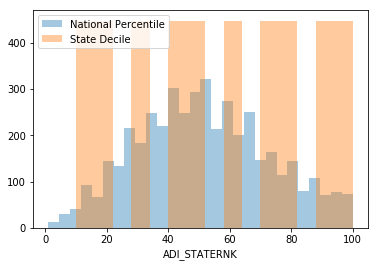

In [31]:
sns.distplot(wi_adi['ADI_NATRANK'],kde=False,label='National Percentile')
sns.distplot(wi_adi['ADI_STATERNK']*10.0,kde=False,label='State Decile')
plt.legend()

### Census Shapefiles
Link the FIPS codes in the ADI data to their corresponding spatial boundaries so the shapes and the data are in the same dataframe. 

In [3]:
wi_shp = gpd.read_file(os.path.join('../../gz_2010_55_150_00_500k/gz_2010_55_150_00_500k.shp'))
wi_shp.head()

,GEO_ID,STATE,COUNTY,TRACT,BLKGRP,NAME,LSAD,CENSUSAREA,geometry
0,1500000US550250025002,55,025,002500,2,2,BG,0.884,"POLYGON ((-89.348203 43.121292, -89.338515 43...."
1,1500000US550250026011,55,025,002601,1,1,BG,0.315,"POLYGON ((-89.32147399999999 43.118899, -89.31..."
2,1500000US550250026012,55,025,002601,2,2,BG,0.281,"POLYGON ((-89.316678 43.107006, -89.3166909999..."
3,1500000US550250026021,55,025,002602,1,1,BG,0.470,"POLYGON ((-89.30472499999999 43.150194, -89.30..."
4,1500000US550250026023,55,025,002602,3,3,BG,0.374,"POLYGON ((-89.315584 43.122916, -89.3152839999..."


It looks like the column 'GEO_ID' has the 12-digit FIPS codes following the letters 'US'. Create a new column with just the 12-digit FIPS codes.

In [9]:
wi_shp['FIPS'] = wi_shp['GEO_ID'].apply(lambda x: x.split("US")[-1])

# Just subset to Dane County:
dane = wi_shp[wi_shp['COUNTY']=='025']

In [17]:
# Join ADI to the Dane county dataframe:
adi_dane = dane[['FIPS','CENSUSAREA','geometry','TRACT']].merge(wi_adi,how='left',on='FIPS')
adi_dane.head()

,FIPS,CENSUSAREA,geometry,TRACT,GISJOIN,ADI_STATERNK,ADI_NATRANK
0,550250025002,0.884,"POLYGON ((-89.348203 43.121292, -89.338515 43....",002500,G55002500025002,6.0,56.0
1,550250026011,0.315,"POLYGON ((-89.32147399999999 43.118899, -89.31...",002601,G55002500026011,8.0,63.0
2,550250026012,0.281,"POLYGON ((-89.316678 43.107006, -89.3166909999...",002601,G55002500026012,6.0,51.0
3,550250026021,0.470,"POLYGON ((-89.30472499999999 43.150194, -89.30...",002602,G55002500026021,4.0,39.0
4,550250026023,0.374,"POLYGON ((-89.315584 43.122916, -89.3152839999...",002602,G55002500026023,7.0,57.0


In [37]:
# THere are two tracts without ADI data - let's drop those from the dataframe
print("Was",len(adi_dane))
adi_dane = adi_dane[adi_dane['CENSUSAREA']>0.0]
print("Is",len(adi_dane))

Was 310
Is 308


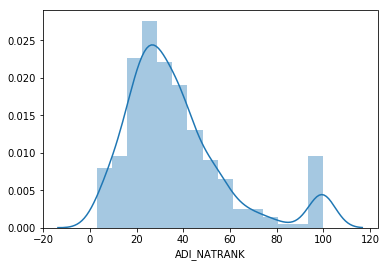

In [39]:
sns.distplot(adi_dane['ADI_NATRANK'])

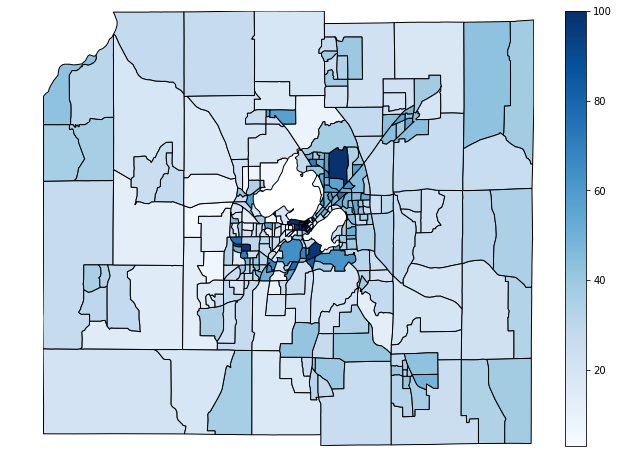

In [46]:
geoplot.choropleth(adi_dane,hue='ADI_NATRANK',cmap='Blues',k=None,legend=True,figsize=(11,8))